# Forecasting incoming international students

This project aims to forecast international students in Australia in the upcoming years.

I have obtained the data from the Department of Education, skills and employment of Australian government.

# Data selecting and cleaning

The data provided by the department is of the form of pivot table. It provdes monthly enrolments and commencements of international students from different sectors (Higher education, VET, Schools, ELICOS, non-award).

In this project, since the we are interested in incoming international students of all forms, I am extracting only the total of international students monthly from all years the department can provide (2002 to 2020).

The file international_students.csv is the file I created by extracting data from the original pivot table.

In [1]:
# read data
data <- read.csv("international_student.csv", header = TRUE)
head(data)

class(data$Student.Enrolment)
class(data$Student.Commencement)

ï..Year,Month,Student.Enrolment.,Student.Commencement.,X,X.1,X.2,X.3,X.4,X.5,...,X.27,X.28,X.29,X.30,X.31,X.32,X.33,X.34,X.35,X.36
2002,January,"126,316","12,911",NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2003,January,"148,417","13,493",NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2004,January,"162,158","13,737",NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2005,January,"176,972","16,856",NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2006,January,"190,367","18,078",NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2007,January,"213,006","23,149",NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "factor"

[1] "factor"

In [2]:
# take only the first 4 columns
data <- data[,1:4]

# give correct column namems
colnames(data) <- c("year", "Month", "Student_Enrolment", "Student_Commencement")

head(data)

year,Month,Student_Enrolment,Student_Commencement
2002,January,"126,316","12,911"
2003,January,"148,417","13,493"
2004,January,"162,158","13,737"
2005,January,"176,972","16,856"
2006,January,"190,367","18,078"
2007,January,"213,006","23,149"


Here we can see that the data is ordered first by month, then by year.

Clearly it is a time-series data and we need to order the data from month to month, then year to year.

In [3]:
# correct data type for Student
data$Student_Enrolment <- as.numeric(gsub(",", "", data$Student_Enrolment))
data$Student_Commencement <- as.numeric(gsub(",", "", data$Student_Commencement))

In [4]:
# we use student_Commencement only for this project
data <- data[,-3]

In [5]:
new_data <- c()

# order the data correctly
for (j in 1:19){
  for (i in 1:12){
        new_data[i+12*(j-1)] <- data[19*(i-1)+j,3]
  }   
}

data <- new_data[1:227]

head(data)

[1] 12911 45051 73894 82017 87007 91880

In [6]:
data_visual <- data.frame(data)
colnames(data_visual) <- "Student_Commencement"

head(data_visual)

Student_Commencement
12911
45051
73894
82017
87007
91880


# Exploratory data analysis

Now we have what we need. I will first plot the data to see how the data behave.

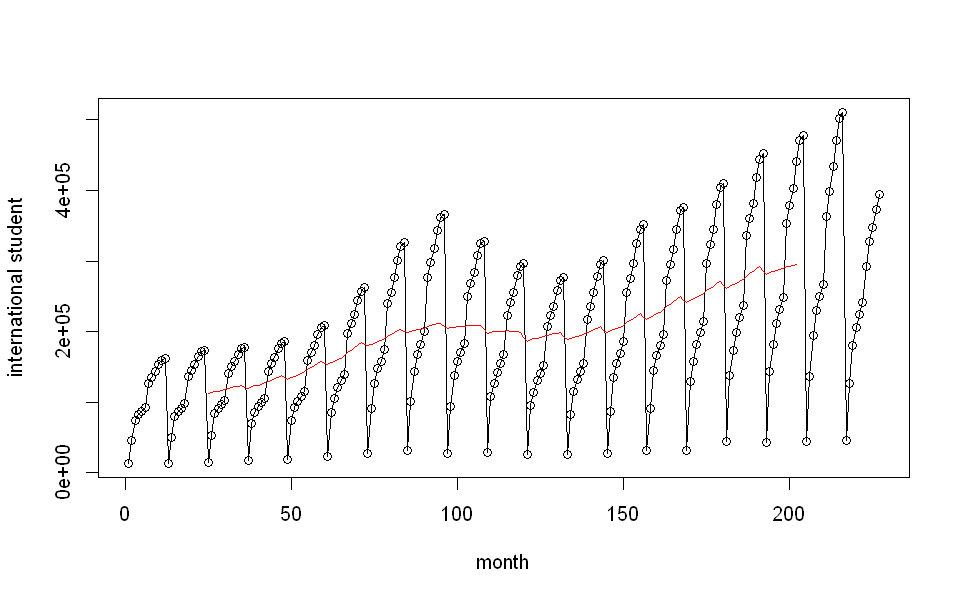

In [7]:
options(repr.plot.width=8, repr.plot.height=5)
plot(data, type = "o", xlab = "month", ylab = "international student")

# smoothing curve to check if the variance is stationary.
ma50 <- filter(data,sides=2,rep(1,50)/50)
lines(ma50, col = 'red')

Here, notice that for each year, it only increase for each month. It is only now I notice that the numbers I got is actually the cumulative sum for each year. 

To make further analysis, I have to reverse it to commencments for each month.

In [8]:
new_data <- c()

# reverse the cumsum function
for (i in 1:19){
    x <- data[((i-1)*12+1):((i-1)*12+12)]
    y <- c(x[1],diff(x))
    new_data <- c(new_data, y)
}

data <- new_data[1:227]

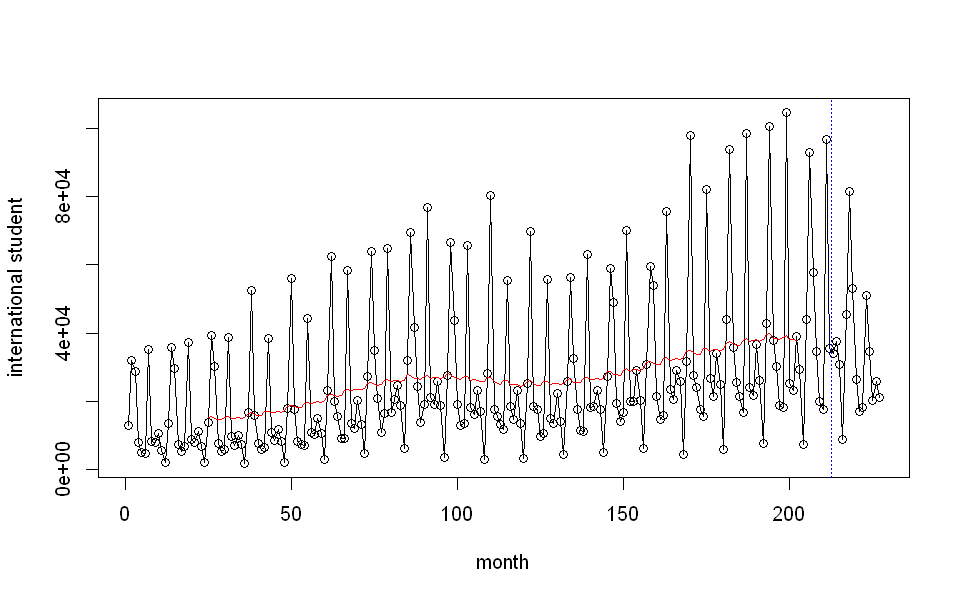

In [32]:
options(repr.plot.width=8, repr.plot.height=5)

plot(data, type = "o", xlab = "month", ylab = "international student")

ma50 <- filter(data,sides=2,rep(1,50)/50)
lines(ma50, col = 'red')

abline(v = 212+0.5, lty = 'dotted', col = "blue")

It looks like the variance is not too stationary. However, it is pretty linear, which is quite a surpise to me, since I assumed there would be a huge impact on international students enrollment during the pandemic in 2020.

In time-series analysis, it is a standard proceedure to take a log on the data when it is fluctuating. I will do it here as well.

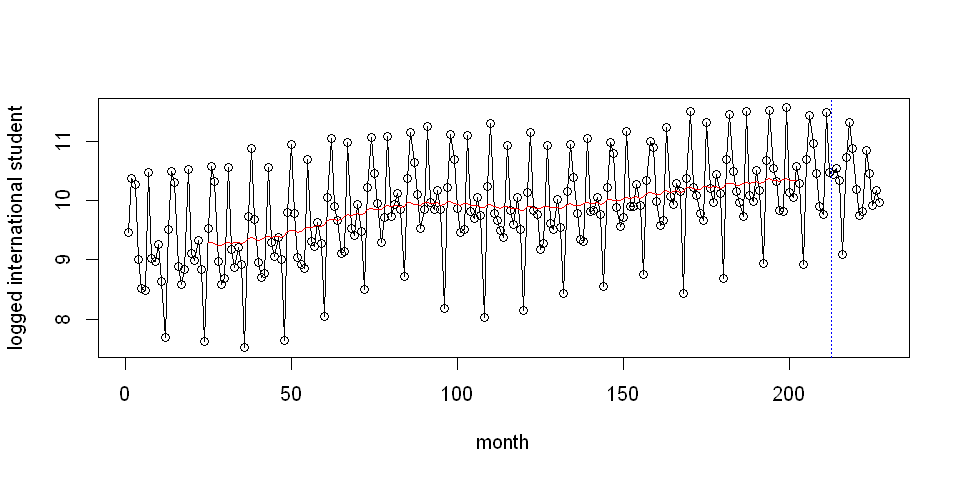

In [33]:
y <- log(data)

options(repr.plot.width=8, repr.plot.height=4)

plot(y, type = "o", xlab = "month", ylab = "logged international student")

ma50 <- filter(y,sides=2,rep(1,50)/50)
lines(ma50, col = 'red')

abline(v = 212+0.5, lty = 'dotted', col = "blue")

The data looks pretty stationary to me now. Next, we will examine the data with knowledge of the enrolment of school.

We know that in Australia, there are typically 2 semesters/sessions, the Autumn and Summer sessions which starts at around February and July respectively. Therefore, it would be reasonable to assume that there is a seasonal trend in the data, with February and July being the peak. Lets plot the data to see if it is true.

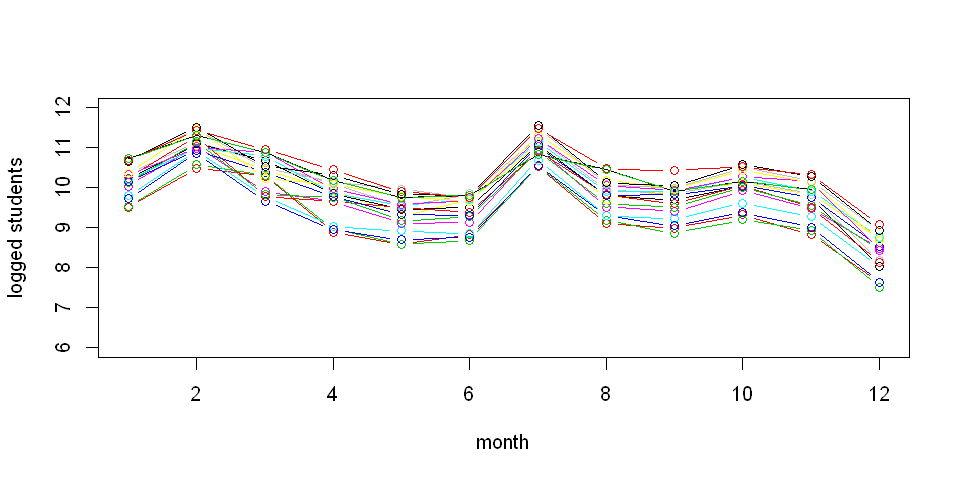

In [11]:
options(repr.plot.width=8, repr.plot.height=4)

# plot the data for each year.
plot(y[((i-1)*12+1):((i-1)*12+12)], type = "l", ylim = c(6,12), xlab = "month", ylab = "logged students") 
for (i in 2:19){
    lines(y[((i-1)*12+1):((i-1)*12+12)], type = "b", col = i)
}

Looks like we are right. With this, we can assume that a seasonal component exists in the series.

Next, we will take a look at the ACF and PACF plot to see which time-series model is suitable for the data.

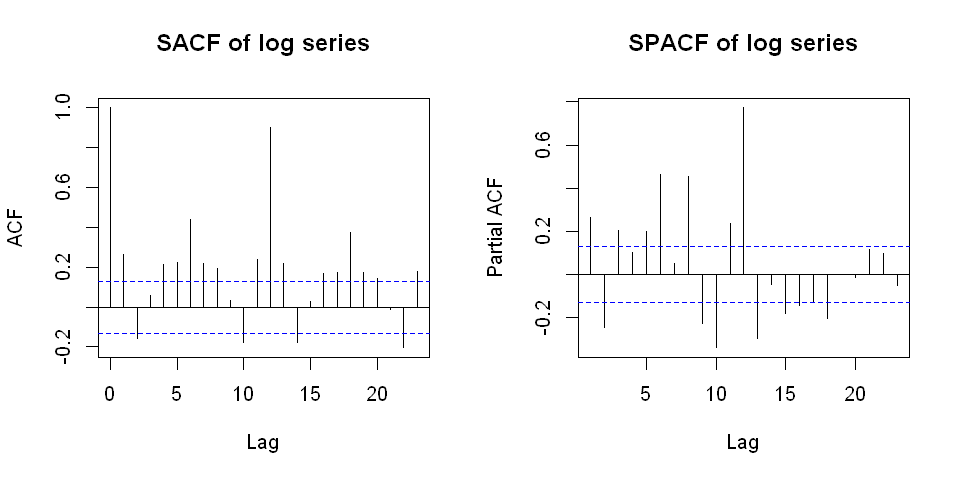

In [12]:
par(mfrow = c(1,2))
options(repr.plot.width=8, repr.plot.height=4)
acf(y, main = 'SACF of log series')
pacf(y, main = 'SPACF of log series')

From the ACF and PACF plot, we can clearly see that there is a high correlation at lag 12. This means that the amount of international students each month depends a lot on the previous year at the same month. This means that the data is definitly seasonal. 

We can use differening to remove the component.

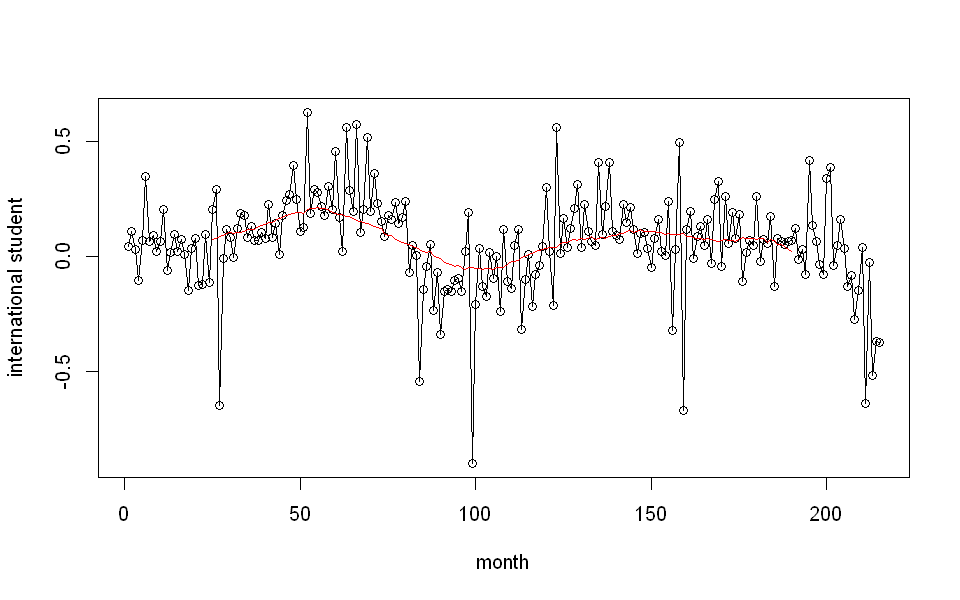

In [35]:
z <- diff(y, 12)

options(repr.plot.width=8, repr.plot.height=5)

plot(z, type = "o", xlab = "month", ylab = "international student")

ma50 <- filter(z,sides=2,rep(1,50)/50)
lines(ma50, col = 'red')

Now that we have differenced the series, we can see some clear decay at the end of the series (after 200, which is 2020 and onwards). Of course, this is due to the pandemic. We will now check on the ACF and PACF plot.

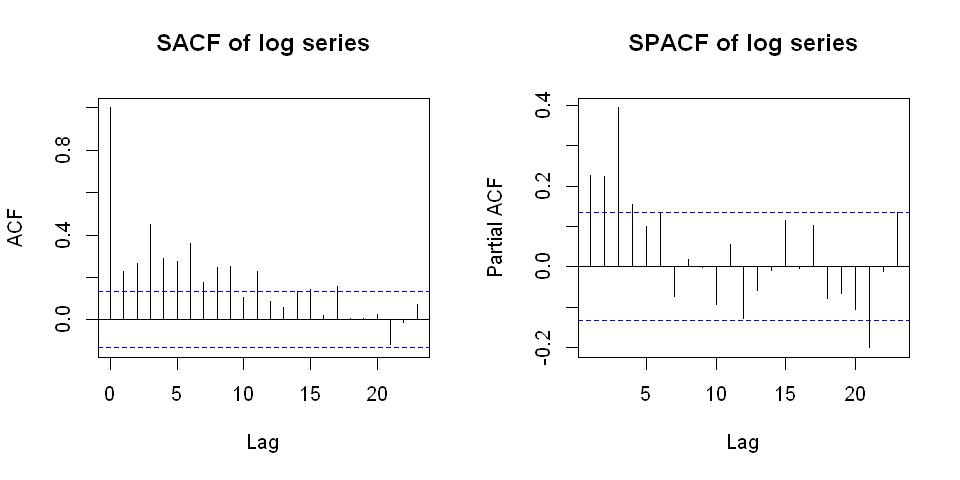

In [14]:
par(mfrow = c(1,2))
options(repr.plot.width=8, repr.plot.height=4)
acf(z, main = 'SACF of log series')
pacf(z, main = 'SPACF of log series')

Finally, it looks 'normal' now, and we can work our techniques from textbooks. We will first check if a unit root exists in the series, using the Augmented Dickey-Fuller test. If the p-value is greater than 0.05, then we fail to reject the null hypnothesis:


\begin{split}
H_0 & : \phi = 1 \text{ (Differencing needed)}\\
H_1 & : \phi \neq 1 \text{ (Differencing not needed)}
\end{split}


In [15]:
library(tseries)

#Augmented Dickey-Fuller test
adf.test(z)

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



	Augmented Dickey-Fuller Test

data:  z
Dickey-Fuller = -1.4037, Lag order = 5, p-value = 0.8261
alternative hypothesis: stationary


The test shows that the p-value of $H_0$ is $0.8261>0.05$. It suggests that we fail to reject $H_0$ at $5\%$ significance level. Therefore, we conclude that unit root exists in the series. Lets take a look at the plot, SACF and SPACF of the differenced log series:

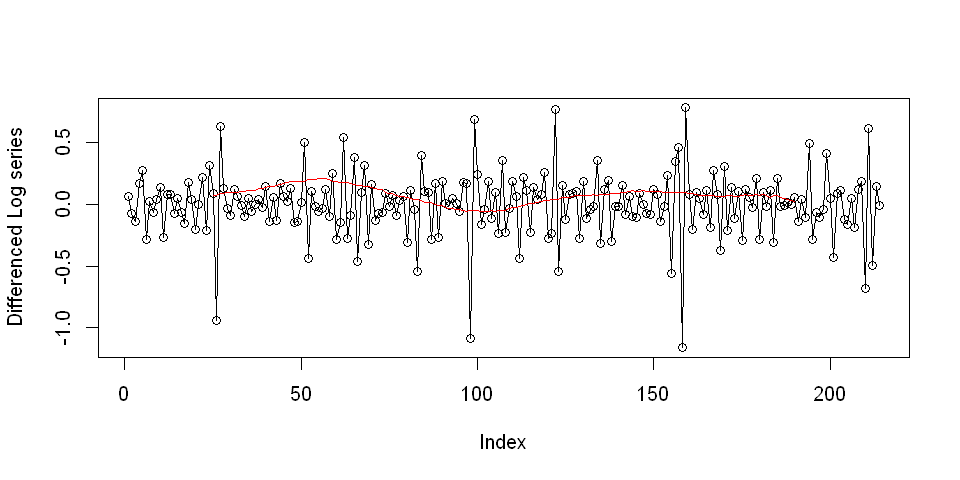

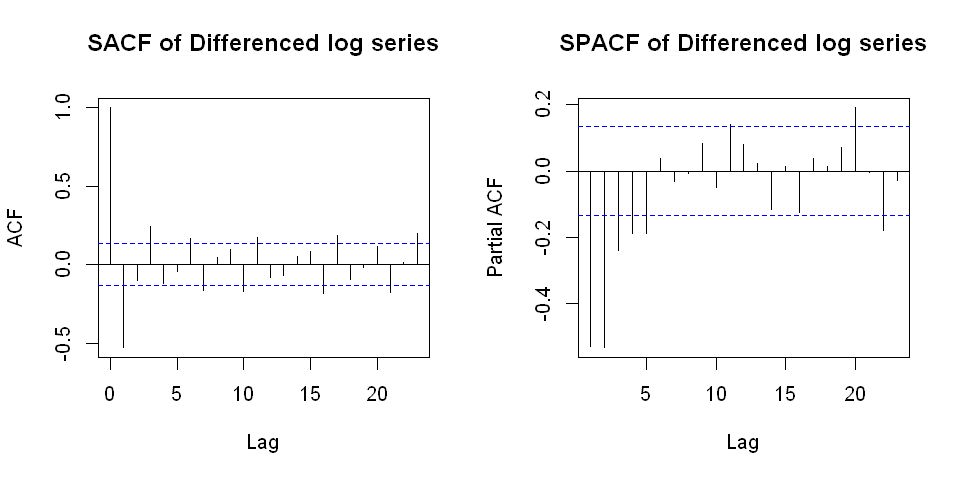

In [16]:
#differencing of the data
z2 <- diff(z)

plot(z2, type = 'o', ylab = 'Differenced Log series')
ma50 <- filter(z,sides=2,rep(1,50)/50)
lines(ma50, col = 'red')
par(mfrow = c(1,2))
acf(z2, main = 'SACF of Differenced log series'); pacf(z2, main = 'SPACF of Differenced log series')

In [17]:
adf.test(z2)

Warning message in adf.test(z2):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  z2
Dickey-Fuller = -8.5305, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


This time it shows that no more differencing is needed. 

# Model fitting

We can see that both the ACF and PACF does not cut off. This suggests we should fit a ARMA model, and with the exiting root, we should fit a ARIMA model with differencing order 1.

To determine the order of p and q, we will use the EACF table.

In [18]:
# eacf is not defined and the following code is programmed by K.S. Chan, Department of Statistics and Actuarial Science, University of Iowa.
eacf <-
  function (z,ar.max=7,ma.max=13) 
  {   
    lag1<-function(z,lag=1){c(rep(NA,lag),z[1:(length(z)-lag)])}
    reupm<-function(m1,nrow,ncol){
      k<-ncol-1
      m2<-NULL
      for (i in 1:k){
        i1<-i+1
        work<-lag1(m1[,i])
        work[1]<--1
        temp<-m1[,i1]-work*m1[i1,i1]/m1[i,i]
        temp[i1]<-0
        m2<-cbind(m2,temp)
      }
      m2}
    ceascf<-function(m,cov1,nar,ncol,count,ncov,z,zm){
      result<-0*seq(1,nar+1)
      result[1]<-cov1[ncov+count]
      for (i in 1:nar) {
        temp<-cbind(z[-(1:i)],zm[-(1:i),1:i])%*%c(1,-m[1:i,i])
        result[i+1]<-acf(temp,plot=FALSE,lag.max=count,drop.lag.0=FALSE)$acf[count+1]
      }
      result
    }
      
    ar.max<-ar.max+1
    ma.max<-ma.max+1
    nar<-ar.max-1
    nma<-ma.max
    ncov<-nar+nma+2
    nrow<-nar+nma+1
    ncol<-nrow-1
    z<-z-mean(z)
    zm<-NULL
    for(i in 1:nar) zm<-cbind(zm,lag1(z,lag=i))
    cov1<-acf(z,lag.max=ncov,plot=FALSE,drop.lag.0=FALSE)$acf
    cov1<-c(rev(cov1[-1]),cov1)
    ncov<-ncov+1
    m1<-matrix(0,ncol=ncol,nrow=nrow)
    for(i in 1:ncol) m1[1:i,i]<-
      ar.ols(z,order.max=i,aic=FALSE,demean=FALSE,intercept=FALSE)$ar
    eacfm<-NULL
    for (i in 1:nma) {
      m2<-reupm(m1=m1,nrow=nrow,ncol=ncol)
      ncol<-ncol-1
      eacfm<-cbind(eacfm, ceascf(m2,cov1,nar,ncol,i,ncov,z,zm))
      m1<-m2}
    work<-1:(nar+1)
    work<-length(z)-work+1
    symbol<-NULL
    for ( i in 1:nma) {
      work<-work-1
      symbol<-cbind(symbol,ifelse(abs(eacfm[,i])>2/work^.5, 'x','o'))}
    rownames(symbol)<-0:(ar.max-1)
    colnames(symbol)<-0:(ma.max-1)
    cat('AR/MA\n')
    print(symbol,quote=FALSE)
    invisible(list(eacf=eacfm,ar.max=ar.max,ma.ma=ma.max,symbol=symbol))
  }
eacf(z2)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x o x o o x x o o x x  o  o  o 
1 x x x o o o x o o o o  o  x  o 
2 x x x x o o o o o o o  o  o  o 
3 x o o x o o o o o o o  o  o  o 
4 x o x x o o o o o o o  o  o  o 
5 x o o x o o o o o o o  o  o  o 
6 x x o x o o o o o o o  o  o  o 
7 x x o o o x o o o o o  o  o  o 


The EACF plot suggests a ARIMA(1,1,3) model might be the best for our data. To make sure we have the best model, we will also fit a ARIMA(0,1,3) and ARIMA(2,1,4) model and determine the best one with the AIC.

In [19]:
#fitting a ARIMA(1,1,3) model to the data
fit113 <- arima(z, order=c(1,1,3), include.mean = FALSE, method = 'ML')

#fitting a ARIMA(0,1,3) model to the data
fit013 <- arima(z, order=c(0,1,3), include.mean = FALSE, method = 'ML')

#fitting a ARIMA(2,1,4) model to the data
fit214 <- arima(z, order=c(2,1,4), include.mean = FALSE, method = 'ML')

fit113
fit013
fit214


Call:
arima(x = z, order = c(1, 1, 3), include.mean = FALSE, method = "ML")

Coefficients:
          ar1      ma1      ma2     ma3
      -0.3457  -0.6832  -0.2592  0.3102
s.e.   0.2532   0.2453   0.2441  0.0818

sigma^2 estimated as 0.03078:  log likelihood = 68.08,  aic = -126.16


Call:
arima(x = z, order = c(0, 1, 3), include.mean = FALSE, method = "ML")

Coefficients:
          ma1     ma2     ma3
      -1.0174  0.0958  0.2137
s.e.   0.0702  0.1074  0.0755

sigma^2 estimated as 0.03099:  log likelihood = 67.32,  aic = -126.64


Call:
arima(x = z, order = c(2, 1, 4), include.mean = FALSE, method = "ML")

Coefficients:
          ar1      ar2     ma1      ma2      ma3     ma4
      -1.5368  -0.8457  0.5395  -0.6135  -0.4533  0.4236
s.e.   0.0451   0.0463  0.0780   0.0720   0.0707  0.0730

sigma^2 estimated as 0.02899:  log likelihood = 72,  aic = -130.01

The AIC actually suggests the ARIMA(2,1,4) model works best with the data. Hence, I will pick it as my model.

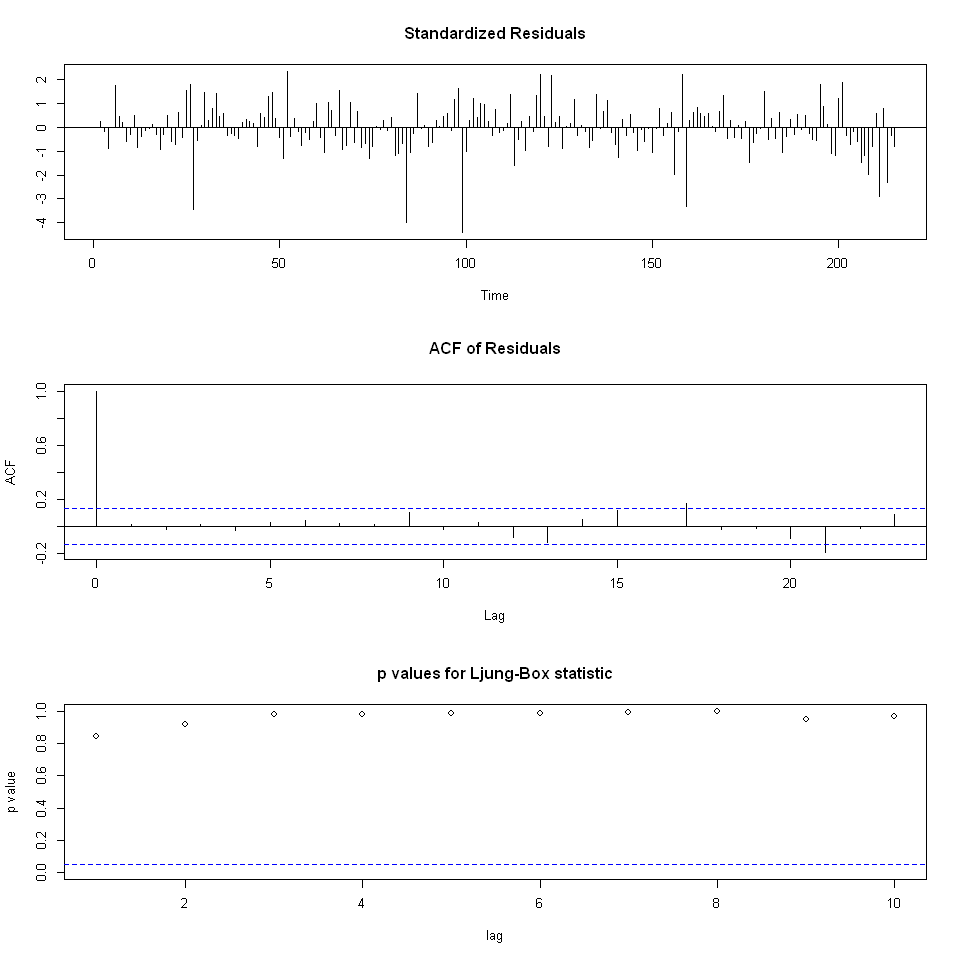

In [20]:
options(repr.plot.width=8, repr.plot.height=8)

#3 diagnostic plots of the model
tsdiag(fit214,golf.lag=25)

In the first plot, it shows that the standardized error is quite random. However, there are a few points which has a variance of -4. Therefore, I won't be too sure about a constant variance. 

In the second plot (SACF of residuals), it shows that 2 points (lag 15 and 17) are out of or close to the blue dashed line. Therefore, by the criteria, we may not reject iid noise hypothesis.

In the third plot, without bringing out the statistic, we can clearly see that the p-value for the Lyung-Box statistic at each lag is way bigger than 0.05. Therefore, at $5\%$ significiant level, we fail to reject the null hypothesis

\begin{equation}
H_0:\rho_1 = \rho_2 = \dots = \rho_{10} = 0
\end{equation}

and it suggests that there is no correlation at lag $1,2, \dots, 10$, and the residuals are iid white noise. This fitted model is actually quite good for the data. The model we fitted is as follows:

\begin{split}
y_t &\sim \text{ARIMA}(2,1,4) \\
\bigtriangledown y_t & = -1.54 y_{t-1} -0.85 y_{t-2} + W_t +0.54 W_{t-1} -0.61 W_{t-2} - 0.45 W_{t-3} + 0.42 W_{t-4} \\
y_t - y_{t-1} & = -1.54 y_{t-1} -0.85 y_{t-2} + W_t +0.54 W_{t-1} -0.61 W_{t-2} - 0.45 W_{t-3} + 0.42 W_{t-4} \\
y_t & = -0.54 y_{t-1} -0.85 y_{t-2} + W_t +0.54 W_{t-1} -0.61 W_{t-2} - 0.45 W_{t-3} + 0.42 W_{t-4} \\
\end{split}

where $W_t \sim \text{WN}(0,0.03)$ and $y_t$ is the lag 12 differenced series of the original logged data. 

# Forecast 

Next, we wish to make predictions on data, and the results are as follows:

In [21]:
#forecasts of the next 12 differenced data
forecast <-predict(fit214,12)

#upper and lower bound of the 12 differenced data
u <- forecast$pred+1.96*forecast$se
l <- forecast$pred-1.96*forecast$se

In [22]:
# predicted values
forecast_values <- forecast$pred
# combine predicted values with the differenced series
whole_series <- c(z, forecast_values)
# reverse differenced series to log series from 13
log_series <- whole_series + y[1:227]
# completed series
log_series <- c(y[1:12], log_series)

In [23]:
# upper interval
upper <- u + y[216:227]

# lower interval
lower <- l + y[216:227]

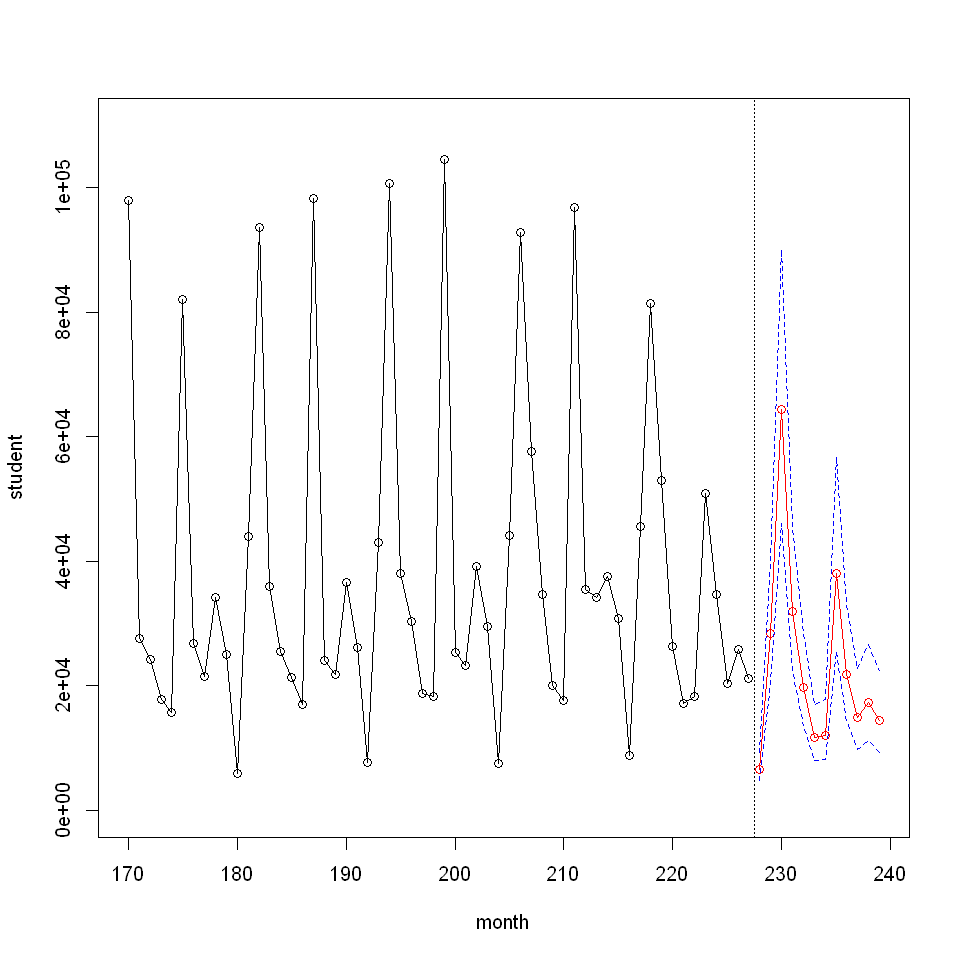

In [24]:
#plot of the monlthy subscription from month 200 to 227 and the forecasts of the next year
month <- seq(170,227)
monthforecast <- seq(228,239)
plot(month, exp(log_series[month]),type='o', xlim = c(170, 239), ylim = c(0,110000), ylab='student')
lines(monthforecast, exp(log_series[228:239]), col = 'red', type = 'o')
lines(monthforecast, exp(upper), col = 'blue', lty = 'dashed')
lines(monthforecast, exp(lower), col = 'blue', lty = 'dashed')
abline(v = 227+0.5, lty = 'dotted')

Visually, we can definitly see a drop across all months in 2021. This is as expected as a travel restriction is enhanced during the panderic. 

I will have a comparision with 2020 numerically to see a more accuratenumber.

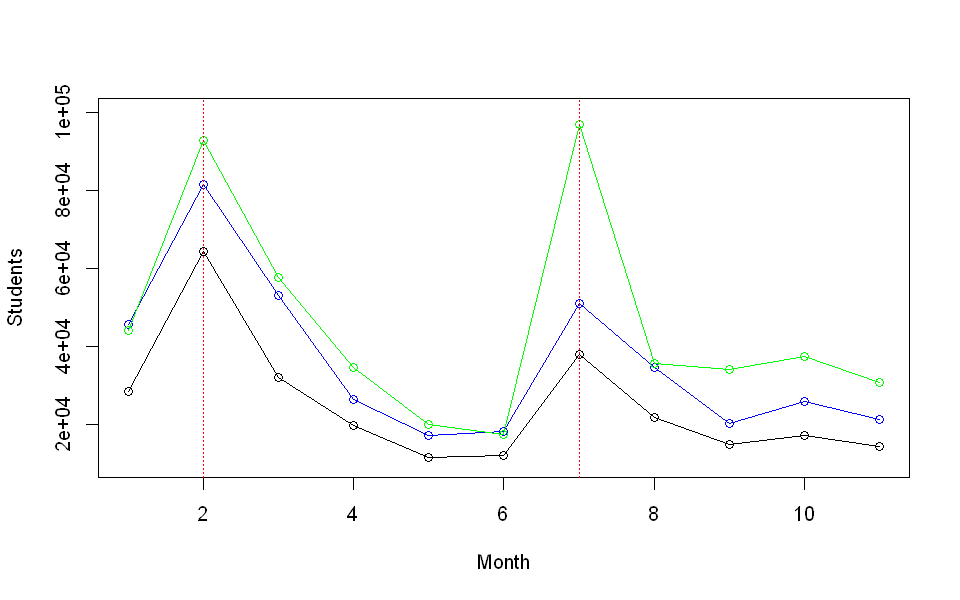

In [42]:
# 2021 forecast
data2021 <- exp(log_series)[229:239]

# 2020 data
data2020 <- exp(log_series)[217:227]

# 2019 data
data2019 <- exp(log_series)[205:215]

# plot the data
plot(data2021, type = "o", ylim = c(10000, 100000), xlab = "Month", ylab = "Students")
lines(data2020, type = "o", col = "blue")
lines(data2019, type = "o", col = "Green")

abline(v = 2, lty = 'dotted', col = "red")
abline(v = 7, lty = 'dotted', col = "red")

In [43]:
# table for percentage difference
difference_percent_2019 <- round((data2020 - data2019)/data2019,2)
difference_percent_2120 <- round((data2021 - data2020)/data2020,2)
compare_table <- as.data.frame(rbind(data2019, data2020, data2021, difference_percent_2019, difference_percent_2120))
colnames(compare_table) <- month.name[1:11]
rownames(compare_table) <- c("Year 2019", "Year 2020", "Year 2021", "percentage_difference_between_20_19", "percentage_difference_between_21_20")

compare_table

# average difference between 2019 and 2020
round(sum(compare_table[4,])/11, 2)

# average difference between 2020 and 2021
round(sum(compare_table[5,])/11, 2)

,January,February,March,April,May,June,July,August,September,October,November
Year 2019,44143.00,92867.00,57691.00,34618.00,19987.00,17571.00,96809.00,35529.00,34125.00,37535.00,30882.00
Year 2020,45621.00,81424.00,52996.00,26325.00,17200.00,18230.00,50931.00,34637.00,20301.00,25905.00,21191.00
Year 2021,28481.76,64394.85,31957.09,19716.93,11612.19,12018.27,38022.41,21794.38,14954.26,17307.81,14397.02
percentage_difference_between_20_19,0.03,-0.12,-0.08,-0.24,-0.14,0.04,-0.47,-0.03,-0.41,-0.31,-0.31
percentage_difference_between_21_20,-0.38,-0.21,-0.40,-0.25,-0.32,-0.34,-0.25,-0.37,-0.26,-0.33,-0.32


[1] -0.19

[1] -0.31

From the above table, we can see the amount of international students have dropped by $19 \%$ on average due to the pandemric.

With our model, we can foresee the number of international students dropping by a huge $30 \%$ on average from 2020 to 2021. 

This is as expected since the outbreak and travel ban happaned closer to the second half of year 2020, The data actually reflects that, as we see the percentage being close to 0 in January, February and March 2020, and we starts to see some significant changes starting from April 2020.

# Conclusion

From the forecasting results, we can see a significant drop in ininternational students for each month. 

To conclude, we can expect the amount of international students to stay dropping until the travel ban is getting lifted.